In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
import statsmodels.api as sm
from arch import arch_model
from pykalman import KalmanFilter

In [2]:

def KF(x, state_mean0 = None, state_cov0 = None, delta = 1e-3):
    if state_cov0 is None:
        trans_cov  = delta / (1 - delta) * np.eye(x.shape[2])
        state_cov0 = np.ones((x.shape[2], x.shape[2]))
    else:
        trans_cov  = delta / (1 - delta) * state_cov0
        
    if state_mean0 is None:
        state_mean0 = [0]*x.shape[2]
   
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=state_mean0,
                      initial_state_covariance= state_cov0,
                      transition_matrices=np.eye(x.shape[2]),
                      observation_matrices=x,
                      observation_covariance=x.shape[2],
                      transition_covariance=trans_cov)
    
    return kf

In [3]:
def plot_kf(df_kf, smooth = False):
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(18,15))
    ax[0].plot(df_kf['slope'], c = 'black', label = "KF Filltered")
    ax[0].fill_between(df_kf.index, df_kf['slope']-2*df_kf['SE slope'], df_kf['slope']+2*df_kf['SE slope'], alpha=0.2)#, facecolor='b')
    
    if smooth:
        ax[0].plot(df_kf['slope smooth'], label = "KF Smoothed")
        ax[0].fill_between(df_kf.index, df_kf['slope smooth']-2*df_kf['SE slope smooth'], df_kf['slope smooth']+2*df_kf['SE slope smooth'], alpha=0.2)#, facecolor='b')
    
    ax[0].set_title('Slope')
#     ax[0].xaxis.set_major_locator(df_kf.index)
    ax[0].legend(loc = 'best')
#     ax[0].xaxis.set_major_formatter(years_fmt)

    ax[1].plot(df_kf['intercept'], c = 'black', label = "KF Filltered")
    ax[1].fill_between(df_kf.index, df_kf['intercept']-2*df_kf['SE intercept'], df_kf['intercept']+2*df_kf['SE intercept'], 
                       alpha=0.2) #, facecolor='b')
    if smooth:
        ax[1].plot(df_kf['intercept smooth'], c = 'black', label = "KF Smoothed")
        ax[1].fill_between(df_kf.index, df_kf['intercept smooth']-2*df_kf['SE intercept smooth'], df_kf['intercept smooth']+2*df_kf['SE intercept smooth'], 
                       alpha=0.2) #, facecolor='b')
    
    ax[1].set_title('Intercept')
    ax[1].legend(loc = 'best')
#     ax[1].xaxis.set_major_locator(years)
#     ax[1].xaxis.set_major_formatter(years_fmt)




In [4]:

def KF_new(x, state_mean0 = None, state_cov0 = None, delta = 1e-3):
    if state_cov0 is None:
        trans_cov  = delta / (1 - delta) * np.eye(x.shape[2])
        state_cov0 = np.ones((x.shape[2], x.shape[2]))
    else:
        trans_cov  = delta / (1 - delta) * state_cov0
        
    if state_mean0 is None:
        state_mean0 = [0]*x.shape[2]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=x.shape[2], # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=state_mean0,
                      initial_state_covariance= state_cov0,
                      transition_matrices=np.eye(x.shape[2]),
                      observation_matrices=x,
                      observation_covariance=x.shape[2],
                      transition_covariance=trans_cov)
    
    return kf

In [5]:
def plot_kf_new(df_kf, smooth = False):
    fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(18,15))
    
    ax[0].plot(df_kf['Mrkt Beta'], c = 'black', label = "KF Filltered")    
    if smooth:
        ax[0].plot(df_kf['smooth Mrkt Beta'], label = "KF Smoothed")    
    ax[0].set_title('Mrkt Beta')
    ax[0].legend(loc = 'best')


    
    ax[1].plot(df_kf['SMB Beta'], c = 'black', label = "KF Filltered")
    if smooth:
        ax[1].plot(df_kf['smooth SMB Beta'], c = 'black', label = "KF Smoothed")
    
    ax[1].set_title('SMB Beta')
    ax[1].legend(loc = 'best')
    
    

    ax[2].plot(df_kf['HML Beta'], c = 'black', label = "KF Filltered")
    if smooth:
        ax[2].plot(df_kf['smooth HML Beta'], c = 'black', label = "KF Smoothed")
    
    ax[2].set_title('HML Beta')
    ax[2].legend(loc = 'best')
    
    
    
    ax[3].plot(df_kf['intercept'], c = 'black', label = "KF Filltered")
    if smooth:
        ax[3].plot(df_kf['smooth intercept'], c = 'black', label = "KF Smoothed")
    
    ax[3].set_title('intercept')
    ax[3].legend(loc = 'best')
    
    



## IBM



In [11]:
IBM=pd.read_csv(r'IBM.csv')['Adj Close'][18:-2].reset_index(drop=True)
MSFT=pd.read_csv(r'MSFT.csv')['Adj Close'][:-2]
DATA_fama=pd.read_csv(r'F-F_Research_Data_5_Factors_2x3.csv')
IBM=np.log(IBM[1:].reset_index(drop=True))-np.log(IBM[0:-1].reset_index(drop=True))
MSFT=np.log(MSFT[1:].reset_index(drop=True))-np.log(MSFT[0:-1].reset_index(drop=True))

In [12]:
y = IBM-DATA_fama['RF'][1:].reset_index(drop=True)
x = DATA_fama['Mkt-RF'][1:].reset_index(drop=True)

In [13]:
X      = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf_X   = KF(X, delta = 1e-4)
state_means_f, state_covs_f = kf_X.filter(y)
state_means_s, state_covs_s = kf_X.smooth(y)

In [14]:
df_kf = pd.DataFrame(state_means_f, columns = ['slope', 'intercept'])
df_kf['SE slope'] = state_covs_f[:,0,0]**.5
df_kf['SE intercept'] = state_covs_f[:,1,1]**.5

df_kf['slope smooth'] = state_means_s[:,0]
df_kf['intercept smooth'] = state_means_s[:,1]
df_kf['SE slope smooth'] = state_covs_s[:,0,0]**.5
df_kf['SE intercept smooth'] = state_covs_s[:,1,1]**.5

df_kf['Ex Ret'] = y.values
df_kf['Mkt-RF'] = x.values
df_kf.index = x.index
df_kf.head()

,slope,intercept,SE slope,SE intercept,slope smooth,intercept smooth,SE slope smooth,SE intercept smooth,Ex Ret,Mkt-RF
0,-0.035422,-0.035422,0.226907,0.226907,-0.111350,-0.111350,0.058801,0.058801,-0.226683,5.07
1,-0.031417,-0.031452,0.226175,0.226192,-0.109197,-0.113652,0.058520,0.059186,-0.253601,-1.57
2,-0.037598,-0.037623,0.197158,0.197279,-0.107067,-0.115937,0.058230,0.059558,-0.201147,2.53
3,-0.038384,-0.038487,0.197372,0.197485,-0.104962,-0.118232,0.057955,0.059930,-0.287871,-0.85
4,-0.044920,-0.045008,0.183866,0.184056,-0.102867,-0.120514,0.057669,0.060293,-0.245897,1.83


In [15]:
slope_ave = df_kf.describe()['slope']['mean']
print(df_kf.describe())

            slope   intercept    SE slope  SE intercept  slope smooth  \
count  680.000000  680.000000  680.000000    680.000000    680.000000   
mean     0.006910   -0.317956    0.062224      0.117094      0.004564   
std      0.018869    0.151094    0.020165      0.011207      0.021543   
min     -0.075893   -0.527301    0.041274      0.094321     -0.111350   
25%      0.006591   -0.461963    0.053136      0.114967      0.005914   
50%      0.011169   -0.344149    0.057893      0.119079      0.009938   
75%      0.016449   -0.184221    0.064801      0.119933      0.014168   
max      0.035479   -0.031452    0.226907      0.226907      0.019599   

       intercept smooth  SE slope smooth  SE intercept smooth      Ex Ret  \
count        680.000000       680.000000           680.000000  680.000000   
mean          -0.305213         0.041760             0.086279   -0.371123   
std            0.099586         0.004733             0.010368    0.273102   
min           -0.450027         0.

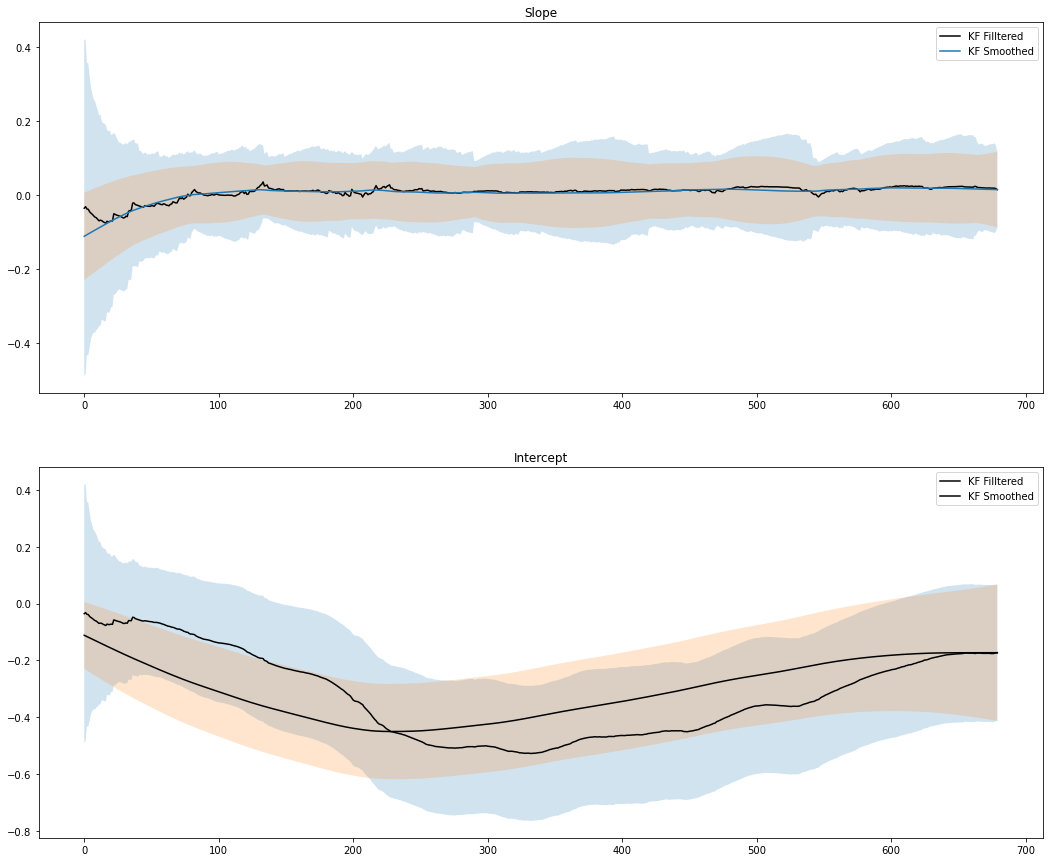

In [16]:
plot_kf(df_kf, smooth = True)

#### 3 Factor IBM

In [17]:
y = IBM-DATA_fama['RF'][1:].reset_index(drop=True)
x = DATA_fama['Mkt-RF'][1:].reset_index(drop=True)
SMB=DATA_fama['SMB'][1:].reset_index(drop=True)
HML=DATA_fama['HML'][1:].reset_index(drop=True)

In [18]:
X = np.expand_dims(np.vstack([[x], [SMB],[HML],[np.ones(len(x))]]).T, axis=1)


kf_X   = KF_new(X, delta = 1e-4)
state_means_f, state_covs_f = kf_X.filter(y)
state_means_s, state_covs_s = kf_X.smooth(y)

In [19]:
df_kf = pd.DataFrame(state_means_f, columns = ['Mrkt Beta','SMB Beta','HML Beta', 'intercept'])
df_kf['SE Mrkt'] = state_covs_f[:,0,0]**.5
df_kf['SE SMB'] = state_covs_f[:,1,1]**.5
df_kf['SE HML'] = state_covs_f[:,2,2]**.5
df_kf['SE intercept'] = state_covs_f[:,3,3]**.5


df_kf['smooth Mrkt Beta'] = state_means_s[:,0]
df_kf['smooth SMB Beta'] = state_means_s[:,1]
df_kf['smooth HML Beta'] = state_means_s[:,2]
df_kf['smooth intercept'] = state_means_s[:,3]


df_kf['SE smooth Mrkt'] = state_covs_s[:,0,0]**.5
df_kf['SE smooth SMB'] = state_covs_s[:,1,1]**.5
df_kf['SE smooth HML'] = state_covs_s[:,2,2]**.5
df_kf['SE smooth intercept'] = state_covs_s[:,3,3]**.5

df_kf.index = x.index
df_kf.head()

,Mrkt Beta,SMB Beta,HML Beta,intercept,SE Mrkt,SE SMB,SE HML,SE intercept,smooth Mrkt Beta,smooth SMB Beta,smooth HML Beta,smooth intercept,SE smooth Mrkt,SE smooth SMB,SE smooth HML,SE smooth intercept
0,-0.030122,-0.030122,-0.030122,-0.030122,0.276547,0.276547,0.276547,0.276547,-0.050390,-0.050390,-0.050390,-0.050390,0.043713,0.043713,0.043713,0.043713
1,-0.025524,-0.025531,-0.025536,-0.025541,0.274740,0.274747,0.274751,0.274756,-0.049465,-0.049740,-0.050151,-0.052230,0.044106,0.044124,0.044359,0.044560
2,-0.030978,-0.030960,-0.030973,-0.030986,0.263738,0.263852,0.263823,0.263796,-0.048553,-0.049093,-0.049910,-0.054062,0.044479,0.044515,0.044978,0.045381
3,-0.035414,-0.035398,-0.035458,-0.035457,0.261605,0.261718,0.261637,0.261626,-0.047634,-0.048450,-0.049670,-0.055892,0.044835,0.044882,0.045573,0.046181
4,-0.038442,-0.038347,-0.038445,-0.038468,0.260283,0.260474,0.260357,0.260321,-0.046720,-0.047811,-0.049420,-0.057717,0.045170,0.045229,0.046145,0.046960


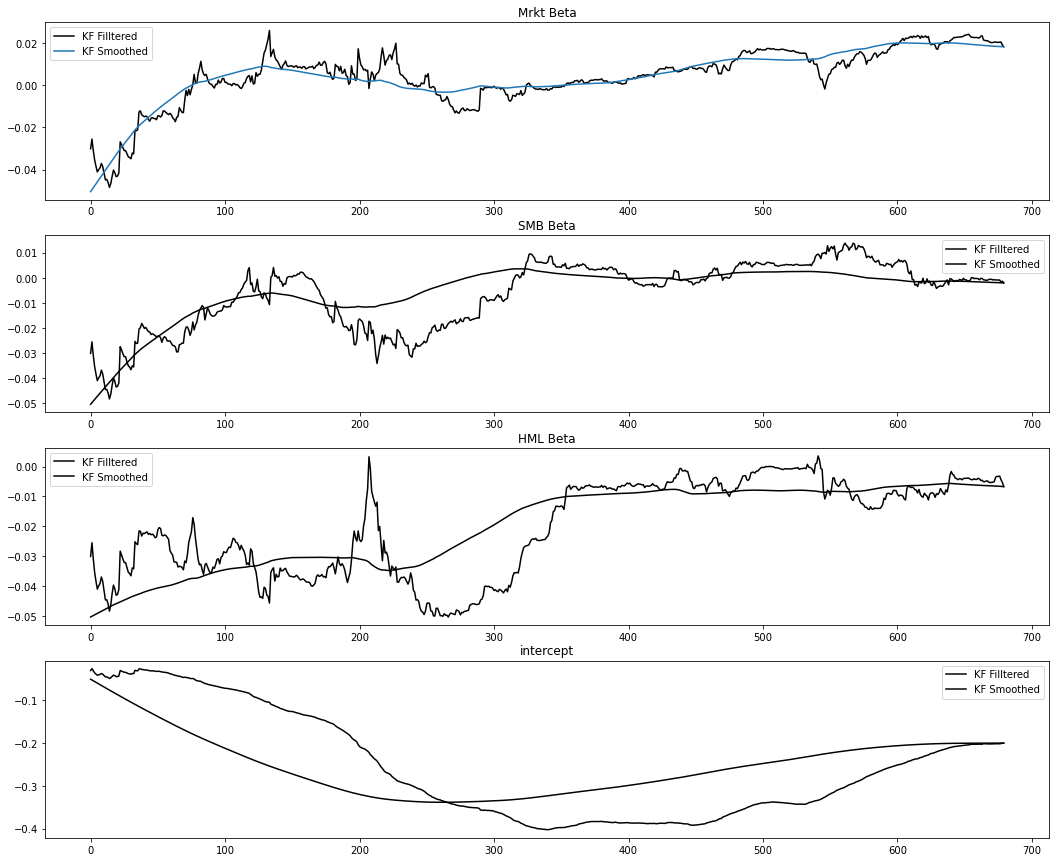

In [20]:
plot_kf_new(df_kf, smooth = True)

## Microsoft

In [21]:
y = MSFT-DATA_fama['RF'][273:].reset_index(drop=True)
x =DATA_fama['Mkt-RF'][273:].reset_index(drop=True)

In [22]:
X      = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf_X   = KF(X, delta = 1e-4)
state_means_f, state_covs_f = kf_X.filter(y)
state_means_s, state_covs_s = kf_X.smooth(y)

In [23]:
df_kf = pd.DataFrame(state_means_f, columns = ['slope', 'intercept'])
df_kf['SE slope'] = state_covs_f[:,0,0]**.5
df_kf['SE intercept'] = state_covs_f[:,1,1]**.5

df_kf['slope smooth'] = state_means_s[:,0]
df_kf['intercept smooth'] = state_means_s[:,1]
df_kf['SE slope smooth'] = state_covs_s[:,0,0]**.5
df_kf['SE intercept smooth'] = state_covs_s[:,1,1]**.5

df_kf['Ex Ret'] = y.values
df_kf['Mkt-RF'] = x.values
df_kf.index = x.index
df_kf.head()

,slope,intercept,SE slope,SE intercept,slope smooth,intercept smooth,SE slope smooth,SE intercept smooth,Ex Ret,Mkt-RF
0,0.053340,0.053340,0.976808,0.976808,-0.041297,-0.041297,0.045026,0.045026,-0.360667,-1.31
1,-0.064789,-0.064781,0.243700,0.243948,-0.039247,-0.043356,0.044251,0.045780,-0.408162,4.62
2,-0.092618,-0.092637,0.230235,0.230471,-0.037155,-0.045407,0.043506,0.046521,-0.649456,1.03
3,-0.003567,-0.004182,0.172257,0.173475,-0.035033,-0.047429,0.042737,0.047242,-0.595993,-6.45
4,-0.029757,-0.030305,0.130715,0.132560,-0.033162,-0.049413,0.042013,0.047932,-0.460000,6.07


In [24]:
slope_ave = df_kf.describe()['slope']['mean']
print(df_kf.describe())

            slope   intercept    SE slope  SE intercept  slope smooth  \
count  408.000000  408.000000  408.000000    408.000000    408.000000   
mean     0.006167   -0.138116    0.063170      0.111083      0.005569   
std      0.013375    0.062596    0.048221      0.046293      0.011315   
min     -0.092618   -0.223590    0.044280      0.068168     -0.041297   
25%     -0.003523   -0.194213    0.052860      0.101887     -0.004722   
50%      0.011398   -0.143418    0.059689      0.114894      0.010849   
75%      0.015781   -0.102835    0.066587      0.118310      0.014289   
max      0.053340    0.053340    0.976808      0.976808      0.016550   

       intercept smooth  SE slope smooth  SE intercept smooth      Ex Ret  \
count        408.000000       408.000000           408.000000  408.000000   
mean          -0.137794         0.042095             0.085355   -0.237516   
std            0.029972         0.004088             0.015260    0.217317   
min           -0.176250         0.

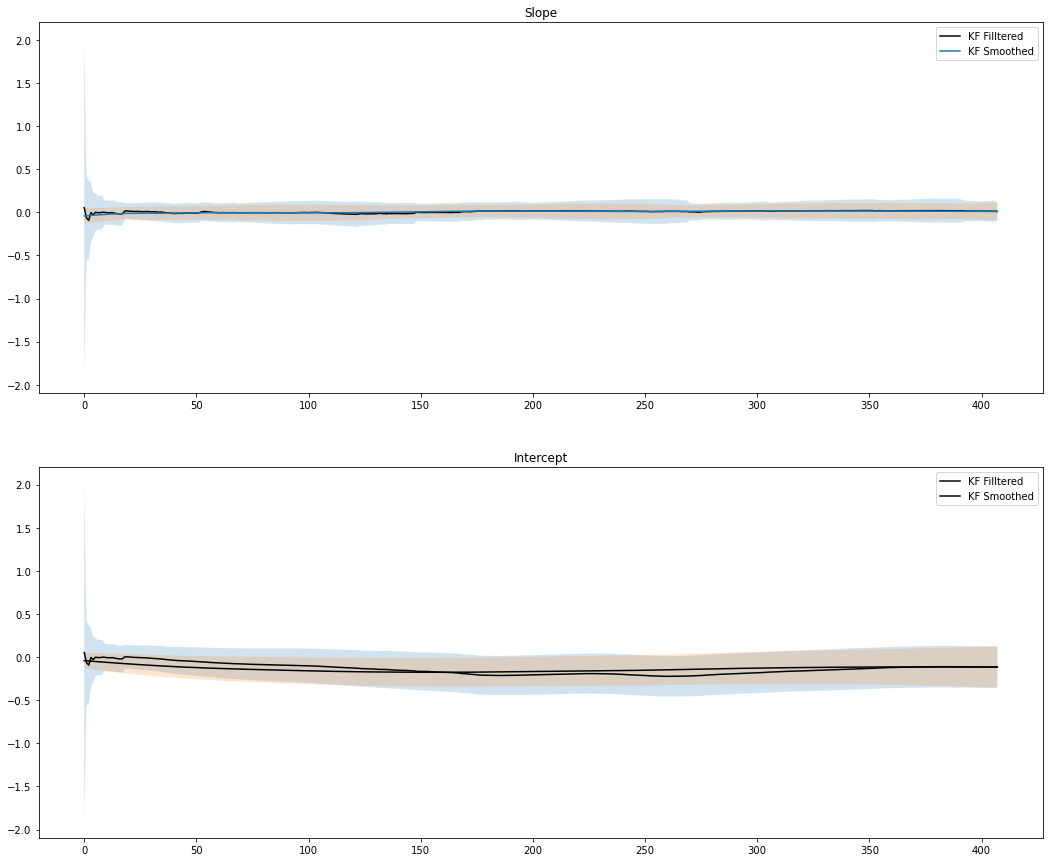

In [25]:
plot_kf(df_kf, smooth = True)

#### 3 Factor MSFT

In [26]:
y = MSFT-DATA_fama['RF'][273:].reset_index(drop=True)
x = DATA_fama['Mkt-RF'][273:].reset_index(drop=True)
SMB=DATA_fama['SMB'][273:].reset_index(drop=True)
HML=DATA_fama['HML'][273:].reset_index(drop=True)

In [27]:
X = np.expand_dims(np.vstack([[x], [SMB],[HML],[np.ones(len(x))]]).T, axis=1)


kf_X   = KF_new(X, delta = 1e-4)
state_means_f, state_covs_f = kf_X.filter(y)
state_means_s, state_covs_s = kf_X.smooth(y)

In [28]:
df_kf = pd.DataFrame(state_means_f, columns = ['Mrkt Beta','SMB Beta','HML Beta', 'intercept'])
df_kf['SE Mrkt'] = state_covs_f[:,0,0]**.5
df_kf['SE SMB'] = state_covs_f[:,1,1]**.5
df_kf['SE HML'] = state_covs_f[:,2,2]**.5
df_kf['SE intercept'] = state_covs_f[:,3,3]**.5


df_kf['smooth Mrkt Beta'] = state_means_s[:,0]
df_kf['smooth SMB Beta'] = state_means_s[:,1]
df_kf['smooth HML Beta'] = state_means_s[:,2]
df_kf['smooth intercept'] = state_means_s[:,3]


df_kf['SE smooth Mrkt'] = state_covs_s[:,0,0]**.5
df_kf['SE smooth SMB'] = state_covs_s[:,1,1]**.5
df_kf['SE smooth HML'] = state_covs_s[:,2,2]**.5
df_kf['SE smooth intercept'] = state_covs_s[:,3,3]**.5

df_kf.index = x.index
df_kf.head()

,Mrkt Beta,SMB Beta,HML Beta,intercept,SE Mrkt,SE SMB,SE HML,SE intercept,smooth Mrkt Beta,smooth SMB Beta,smooth HML Beta,smooth intercept,SE smooth Mrkt,SE smooth SMB,SE smooth HML,SE smooth intercept
0,0.021333,0.021333,0.021333,0.021333,0.992877,0.992877,0.992877,0.992877,-0.027487,-0.027487,-0.027487,-0.027487,0.045436,0.045436,0.045436,0.045436
1,-0.074508,-0.074495,-0.074497,-0.074500,0.425255,0.425521,0.425469,0.425419,-0.026657,-0.026804,-0.027716,-0.028777,0.045376,0.045989,0.046246,0.046278
2,-0.115463,-0.115442,-0.115480,-0.115470,0.373637,0.373961,0.373807,0.373782,-0.025792,-0.026130,-0.027946,-0.030059,0.045305,0.046509,0.047019,0.047100
3,-0.017362,-0.017401,-0.017895,-0.017703,0.293782,0.294306,0.294951,0.294584,-0.024913,-0.025469,-0.028156,-0.031327,0.045204,0.046999,0.047761,0.047902
4,-0.042926,-0.042812,-0.043512,-0.043240,0.216825,0.218608,0.218030,0.218098,-0.024144,-0.024868,-0.028284,-0.032578,0.045101,0.047481,0.048455,0.048679


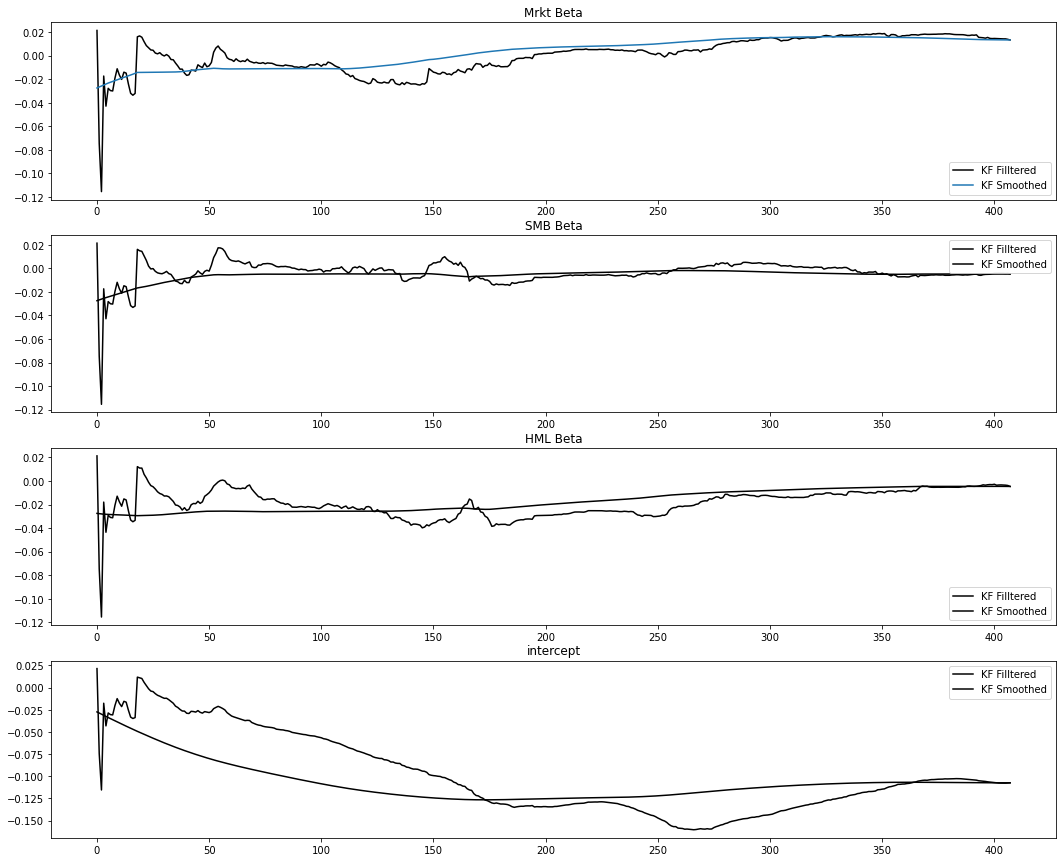

In [29]:
plot_kf_new(df_kf, smooth = True)